In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

**1. Perform a complete Box-Jenkins analysis to arrive at what you believe to be the optimum ARIMA(p,d,q) model**

**(a) Plot the series.**

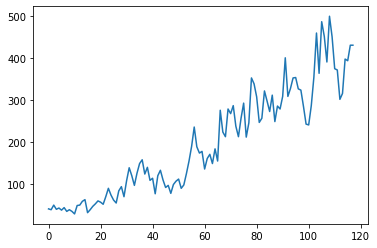

In [ ]:
robb_df = pd.read_csv("monthly-robberies.csv", header=0, index_col=0)
X = robb_df.values.flatten()
plt.plot(X)
plt.show()

**(b) Perform a Dickey-Fuller test on the series.  Is the series stationary?**

In [ ]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for k, v in result[4].items():
    print('\t%s: %.3f' % (k,v))

ADF Statistic: 1.001102
p-value: 0.994278
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


After performing the Dickey-Fuller test on the series, the p-value of the series is greater than 0.05. Hence, the series in **not stationary.**

**(c) Plot the ACF & PACF and observe the trends.**

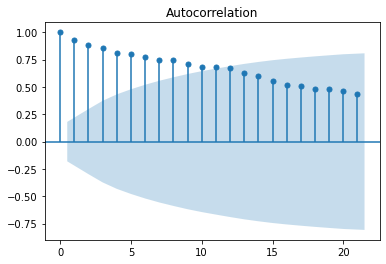

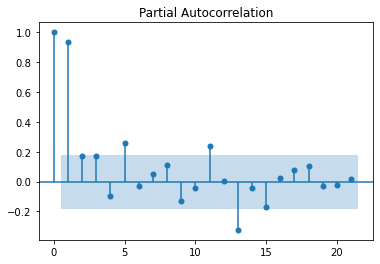

In [ ]:
plot_acf(robb_df.values)
plot_pacf(robb_df.values)
plt.show()

**(d) Perform differencing on the series.**

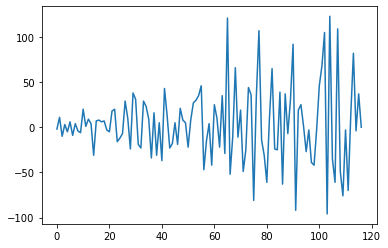

In [ ]:
diff = list()
for i in range(1, len(X)):
    val = X[i] - X[i-1]
    diff.append(val)
    
plt.plot(diff)
plt.show()

**(e) Is the differenced series stationary?**

In [ ]:
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for k, v in result[4].items():
    print('\t%s: %.3f' % (k,v))

ADF Statistic: -7.428564
p-value: 0.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


After first order of differencing, the series becomes stationary.

**(f) Plot the ACF & PACF of the differenced data and select the p & q orders.**

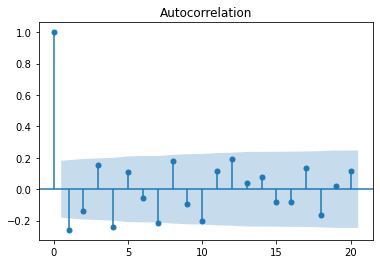

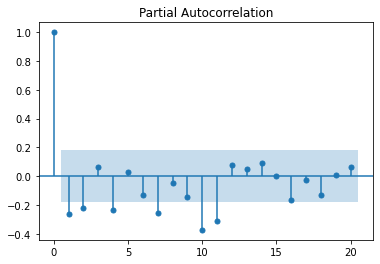

In [ ]:
plot_acf(diff, lags=20)
plot_pacf(diff, lags = 20)
plt.show()

The values of p and q are 2 and 1 respectively, since it is an ARMA(2,1)

**(g) Run an ARIMA analysis with the original series and the (p,d,q) you've deduced from above.**

In [ ]:
model = ARIMA(X, order=(2,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  117
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -592.107
Method:                       css-mle   S.D. of innovations             38.118
Date:                Sat, 23 Apr 2022   AIC                           1194.213
Time:                        09:16:22   BIC                           1208.024
Sample:                             1   HQIC                          1199.820
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2980      2.539      1.299      0.197      -1.679       8.275
ar.L1.D.y     -0.8811      0.168     -5.235      0.000      -1.211      -0.551
ar.L2.D.y     -0.3641      0.086     -4.243      0.0

**(h) Plot the residuals.**

[]

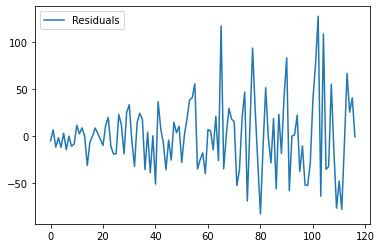

In [ ]:
residuals = pd.DataFrame(model_fit.resid, columns=['Residuals'])
residuals.plot()
plt.plot()

**(i) Plot the residual distribution (kind='kde').**

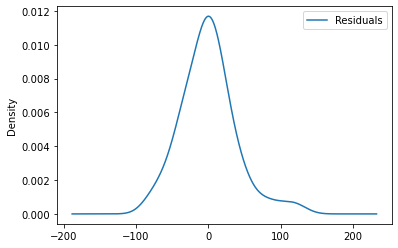

In [ ]:
residuals.plot(kind='kde')
plt.show()

**(j) Print the residuals summary.**

In [ ]:
print(residuals.describe())

        Residuals
count  117.000000
mean     0.002947
std     38.282841
min    -83.077243
25%    -25.757228
50%     -0.239492
75%     18.435428
max    127.310522


**(k) Plot the ACF & PACF and observe for residual correlations.**

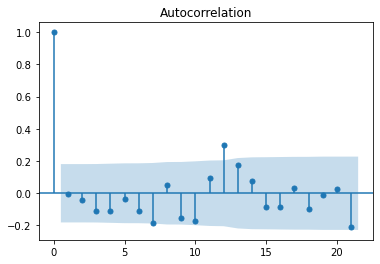

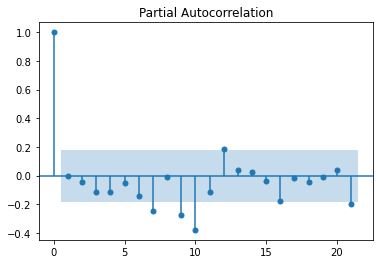

In [ ]:
plot_acf(residuals.values)
plot_pacf(residuals.values)
plt.show()

**(l) Compare the model results series to the actuals:**

   **i. Convert the residuals to the series estimated by ARIMA (hint: resids = y - yhat).**

In [ ]:
resids = residuals.Residuals
dhat = list()
for i in range(len(resids)):
    val = diff[i] - resids[i]
    dhat.append(val)

**ii. Add back the differencing to compare with the original series.**

In [ ]:
yhat = list()
yhat.append(X[0])
for i in range(len(dhat)):
    val = dhat[i] + X[i]
    yhat.append(val)

**iii. Plot the actual and modeled results on the same graph.**

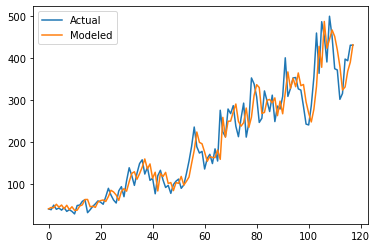

In [ ]:
plt.plot(X, label = 'Actual')
plt.plot(yhat, label = 'Modeled')
plt.legend()
plt.show()

**2. Create a AIC grid search and run 'robberies.csv' through it to find the optimum p,d,q order. What is the optimum p,d,q order?**

In [ ]:
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
best_score, best_cfg = float("inf"), None
warnings.filterwarnings('ignore')
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model = ARIMA(X, order)
                model_fit = model.fit(disp=0)
                AIC = model_fit.aic
                if AIC < best_score:
                    best_score, best_cfg = AIC, order
                #print('ARIMA%s AIC=%0.3f' % (order, AIC))
            except:
                continue
                
print('Best: ARIMA %s AIC=%0.3f' % (best_cfg, best_score))

Best: ARIMA (6, 1, 3) AIC=1182.729


The optimum p,d,q order is 6,1,3

**3. Compare the results of your orginal (p,d,q) estimate to the results from the grid search (p,d,q). Compare the residuals summaries and compare the graphs generated by the script made in 1.l above.**

In [ ]:
def calculate(data, res, d):
    resid = res.values
    dhat = list()
    for i in range(len(res)):
        val = d[i] - resid[i]
        dhat.append(val)

    yhat = list()
    yhat.append(data[0])
    for i in range(len(dhat)):
        val = dhat[i] + data[i]
        yhat.append(val)
        
    return yhat

In [ ]:
org_order = (2,1,1)
model1 = ARIMA(X, org_order)
model_fit1 = model1.fit(disp=0)

grid_order = (6,1,3)
model2 = ARIMA(X, grid_order)
model_fit2 = model2.fit(disp=0)

residuals_org = pd.DataFrame(model_fit1.resid, columns=['ARIMA(2,1,1)'])
residuals_grid = pd.DataFrame(model_fit2.resid, columns=['ARIMA(6,1,3)'])

y_org = calculate(X, residuals_org, diff)
y_grid = calculate(X, residuals_grid, diff)

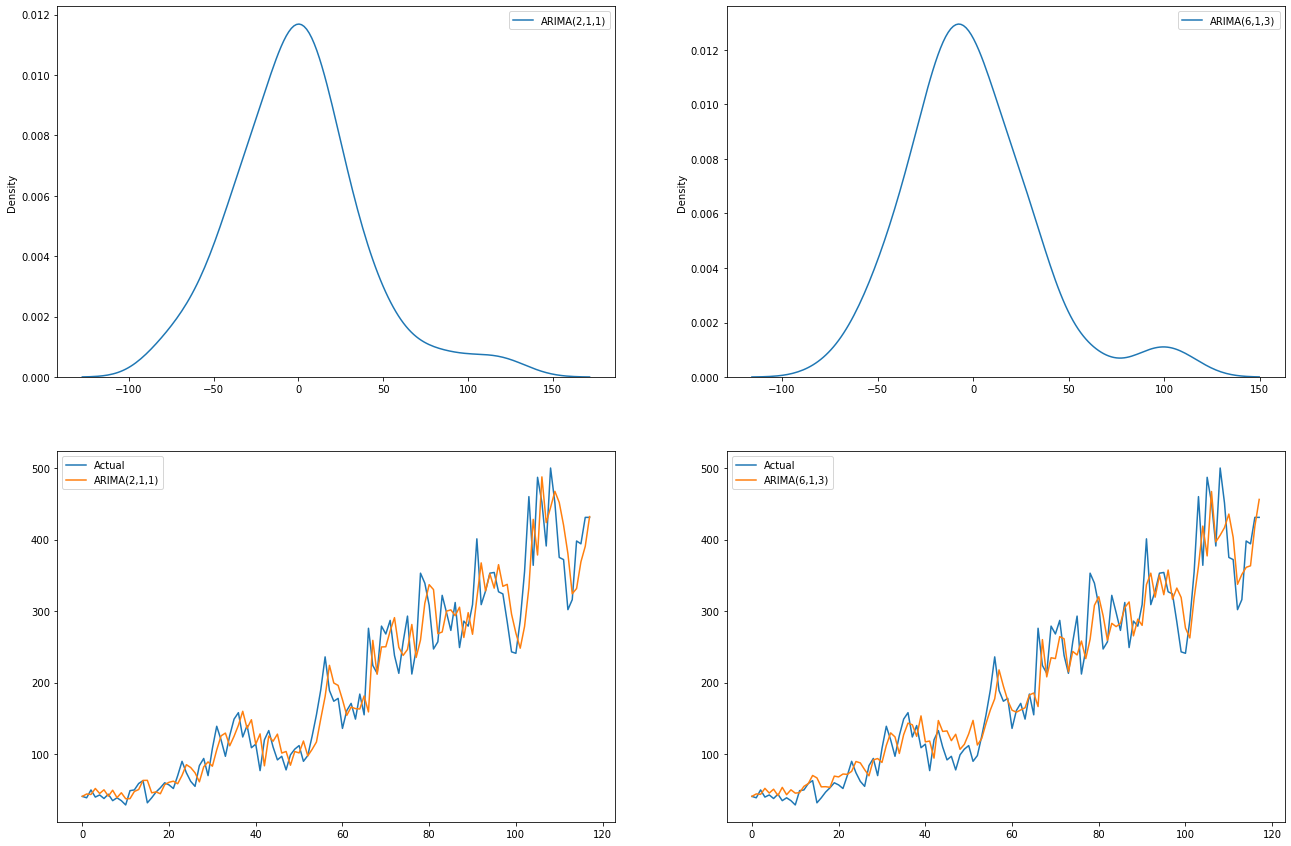

In [ ]:
fig, axs = plt.subplots(2,2)
fig.set_figwidth(22)
fig.set_figheight(15)
# residuals kde
sns.distplot(residuals_org, hist=False, ax = axs[0, 0], label='ARIMA(2,1,1)')
sns.distplot(residuals_grid, hist=False, ax = axs[0, 1], label='ARIMA(6,1,3)')
# ARIMA(2,1,1)
axs[1,0].plot(X, label='Actual')
axs[1,0].plot(y_org, label='ARIMA(2,1,1)')
#ARIMA(6,1,3)
axs[1,1].plot(X, label='Actual')
axs[1,1].plot(y_grid, label='ARIMA(6,1,3)')

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
plt.show()

**4. Forecast 'robberies.csv' based on an ARIMA(2,1,1) model: Split the series into 75% train, 25% test**

**(a) Perform a dynamic forecast for all points in 'test'. Plot the forecasted data and the prediction intervals on top of the actual data**

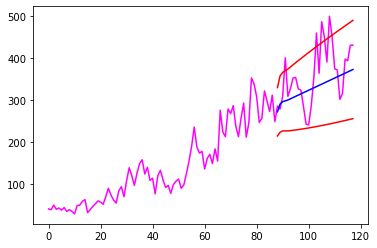


Full Prediction Interval:


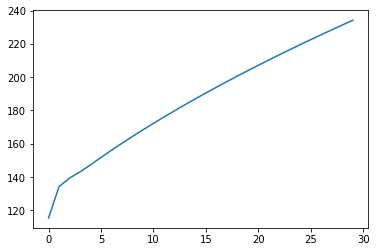

In [ ]:
X = X.astype('float64')
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

p = 2
d = 1
q = 1

model = ARIMA(history, order=(p,d,q))
model_fit = model.fit(disp=0)
predictions = model_fit.forecast(steps=len(test))[0]
limits = pd.DataFrame(model_fit.forecast(steps=len(test))[2])
lowerlimit = limits[0]
upperlimit = limits[1]
predictionint = upperlimit - lowerlimit

plt.plot(X, color='magenta')
plt.plot([None for i in train] + [x for x in predictions], color='blue')
plt.plot([None for i in train] + [x for x in lowerlimit], color='red')
plt.plot([None for i in train] + [x for x in upperlimit], color='red')
plt.show()
print()
print('Full Prediction Interval:')
plt.plot(predictionint)
plt.show()

**(b) Perform a rolling forecast for all points in 'test'. Plot the forecasted data and the prediction intervals on top of the actual data**

predicted=272.287978, expected=286.000000
predicted=298.817210, expected=279.000000
predicted=289.525727, expected=309.000000
predicted=308.059404, expected=401.000000
predicted=364.606464, expected=309.000000
predicted=310.591710, expected=328.000000
predicted=330.552253, expected=353.000000
predicted=344.866379, expected=354.000000
predicted=347.608681, expected=327.000000
predicted=336.462004, expected=324.000000
predicted=337.337389, expected=285.000000
predicted=315.233016, expected=243.000000
predicted=287.444045, expected=241.000000
predicted=279.420128, expected=287.000000
predicted=304.985617, expected=355.000000
predicted=347.327531, expected=460.000000
predicted=419.031810, expected=364.000000
predicted=349.529539, expected=487.000000
predicted=430.011832, expected=452.000000
predicted=427.221214, expected=391.000000
predicted=389.246433, expected=500.000000
predicted=461.709212, expected=451.000000
predicted=457.925364, expected=375.000000
predicted=429.096565, expected=372

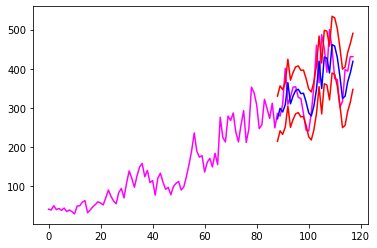


Full Prediction Interval:


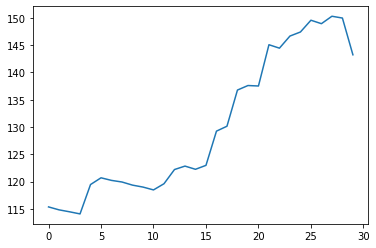

In [ ]:
predictions = list()
lowerlimit = list()
upperlimit = list()
predictionint = list()

for i in range(len(test)):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit(disp=0)
    
    yhat = model_fit.forecast()[0]
    lolim = model_fit.forecast()[2][0][0]
    uplim = model_fit.forecast()[2][0][1]
    interval = uplim - lolim
    
    predictions.append(yhat)
    lowerlimit.append(lolim)
    upperlimit.append(uplim)
    predictionint.append(interval)
    
    obs = test[i]
    history.append(obs)
    
    print('predicted=%f, expected=%f' % (yhat, obs))
    
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

plt.plot(X, color='magenta')
plt.plot([None for i in train] + [x for x in predictions], color='blue')
plt.plot([None for i in train] + [x for x in lowerlimit], color='red')
plt.plot([None for i in train] + [x for x in upperlimit], color='red')
plt.show()
print()
print('Full Prediction Interval:')
plt.plot(predictionint)
plt.show()